# Creating an adversarial example

In this notebook, we first train a network to perform classification between goats, mules, and unicorns.  We'll then create a picture of Bill the Goat which is sneakily altered to be classified as a mule, despite clearly still looking like a goat.

## Training the network

This first part is just a transfer learning example, which does a mediocre, but good-enough-for-our-purposes job of training a network to perform this classification task.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
#from torchvision import datasets, models, transforms
from torchvision.models import resnet18,ResNet18_Weights
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import tqdm
import plotly.graph_objects as go

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [3]:
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomRotation(30),
    v2.RandomHorizontalFlip(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(256,256),antialias=True)
])
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size=(256,256),antialias=True)
])
training_data = torchvision.datasets.ImageFolder('train',
                                                transform=train_transforms)
testing_data = torchvision.datasets.ImageFolder('test',
                                               transform=test_transforms)

In [4]:
train_loader = DataLoader(training_data, batch_size=64, shuffle=True,
                          num_workers=4)
test_loader = DataLoader(testing_data, batch_size=64, num_workers=4)

In [5]:
for param in model.parameters():
    param.requires_grad = False

In [6]:
num_feats = model.fc.in_features
model.fc=nn.Linear(num_feats,len(training_data.classes))
model = model.to('cuda')

### The actual training

In the below training example, we perform the actual training, and then store the version of the network that performs the best on the test set.  We load that again later.

In [7]:
TRAIN = False

if TRAIN:
    criterion = nn.CrossEntropyLoss()
        
    optimizer = optim.Adam(model.fc.parameters(), lr=.001)
    best_test = 1000
        
    EPOCHS = 200
        
    for epoch in tqdm.tqdm(range(EPOCHS)):
        totalloss = 0
        for batch, (X, y) in enumerate(train_loader):
            X = X.to('cuda')
            y = torch.Tensor(y).to('cuda')
            predictions = model(X)
            loss = criterion(predictions, y)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            totalloss += loss.item()
        
        if epoch % 10 == 0:
            totalloss /= len(train_loader)
            print('Loss/train', totalloss, epoch)
            test_loss = 0
        
            with torch.no_grad():
                for batch, (X, y) in enumerate(test_loader):
                    X = X.to('cuda')
                    y = torch.Tensor(y).to('cuda')
                    pred = model(X)
                    test_loss += criterion(pred, y).item()
                test_loss /= len(test_loader)
            print('Loss/test', test_loss, epoch)
            if test_loss < best_test:
                torch.save(model.to('cpu'), 'bestmodel.pt')
                best_test = test_loss
                model = model.to('cuda')
model = torch.load('bestmodel.pt')
model = model.to('cuda')

In [8]:
from sklearn.metrics import accuracy_score
def calc_accuracy(model, dataloader):
    model = model.to('cuda')
    preds = np.array([])
    truth = np.array([])
    for (X,y) in dataloader:
        logits = model(X.to('cuda')).detach()
        batch_preds = torch.argmax(logits, dim=1)
        preds = np.concatenate((preds,batch_preds.cpu().numpy()))
        truth = np.concatenate((truth, y.numpy()))
    return accuracy_score(preds,truth), preds, truth

In [9]:
from sklearn.metrics import confusion_matrix
def build_confusion(predictions, truth, title, labels=None):
    cm = confusion_matrix(predictions, truth)
    import plotly.graph_objects as go
    # Create a Plotly heatmap
    if labels is None:
        labels = [i for i in range(cm.shape[0])]
    fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=[f'Predicted {i}' for i in labels],
        y=[f'Actual {i}' for i in labels],
        colorscale='Greys',  # You can choose any colorscale you like
        colorbar=dict(title='Count')
    ))
    
    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title='Predicted label',
        yaxis_title='Actual label',
    )
    
    # Show plot
    fig.show()

In [10]:
acc, preds, truth = calc_accuracy(model, test_loader)

### Results of training

We can see that we have 97% accuracy on the training set, and 70% accuracy on the testing set.  This isn't that good, we could probably do better, but it's good enough for our purposes.

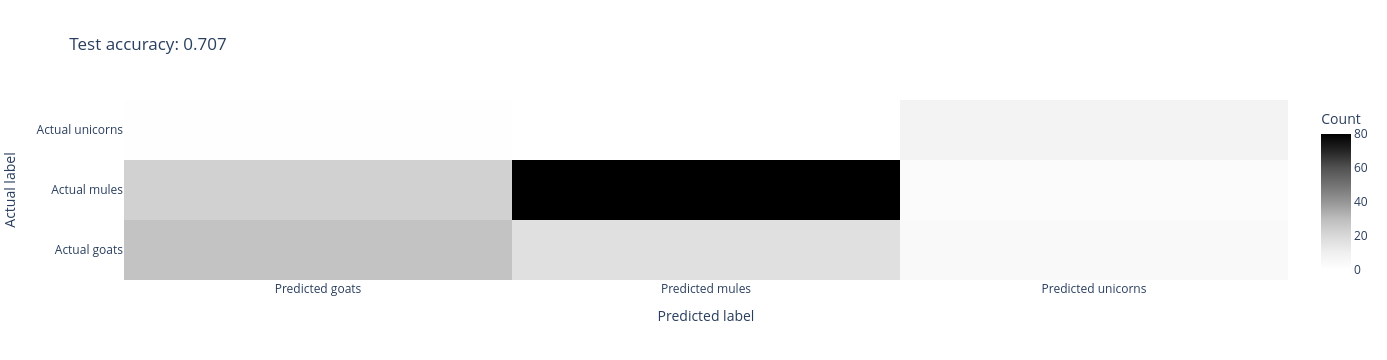

In [11]:
build_confusion(preds, truth, f'Test accuracy: {acc:.3f}',
                labels=training_data.classes)

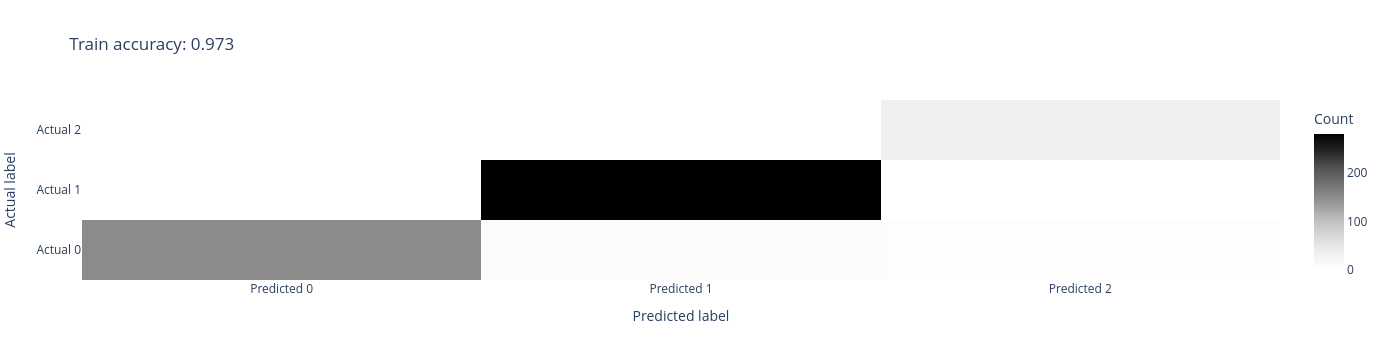

In [12]:
acc, preds, truth = calc_accuracy(model, train_loader)
build_confusion(preds, truth, f'Train accuracy: {acc:.3f}')

## Making the adversarial example.

Here's our picture of Bill the Goat, looking very dapper.  We'd like to alter this image so that it misbehaves, and is classified as a goat.  Note also, I make an object called `initial_goat`, which is Bill before we perform any alterations.  This will allow us to see what sorts of changes were made after the calculations.

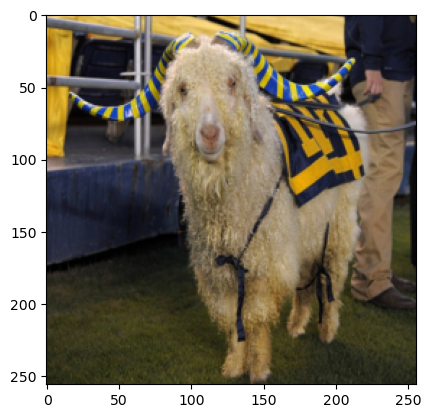

In [13]:
from torchvision.io import read_image
import matplotlib.pyplot as plt

mygoat = read_image('NavyGoat.jpg')
mygoat = test_transforms(mygoat)
initial_goat = torch.clone(mygoat)
plt.imshow(mygoat.permute(1,2,0))

This function lets us check to see what our network believes given our picture.  In this case, we can see that our network is currently classifying it as 95% likely to be a goat (class 0), 4% likely to be a mule (class 1), and 1% likely to be a unicorn.

In [14]:
def checkProbs(da_goat, do_print=True):
    with torch.no_grad():
        model.eval()
        preds = model(da_goat.unsqueeze(0).to('cuda')).detach().cpu()
        probs = nn.Softmax(dim=1)(preds)
        if do_print:
            print(f'Logits: {preds}')
            print(f'Probabilities: {probs}')
        return probs

In [15]:
_ = checkProbs(mygoat)

Logits: tensor([[ 1.3694, -1.7527, -3.0221]])
Probabilities: tensor([[0.9466, 0.0417, 0.0117]])


Below is the Fast Gradient Sign Attack.  Normally, of course, we would go through the following steps:

- Take a picture of a goat
- Push it through the network, getting out the logits
- Compare those logits to the right answer, calculating a loss
- Perform gradient descent on the parameters of the network to minimize the loss

Instead, here we're going to:

- Take a picture of a goat, which we would like to have be misclassified as a mule
- Push it through the network, getting out the logits
- Compare those logits to the desired wrong answer, calculating a loss
- Perform gradient descent on the pixels of the image in order to minimize this loss, while keeping the network unchanged

We're going to use the Fast Gradient Sign Attack to perform this gradient descent.  Here, we take the image, the gradient of the image, and a small hyperparameter epsilon.  We calculate the sign of the gradients, meaning each channel of each pixel will receive a gradient input of +1 or -1.  We then multiply that by epsilon, and subtract it from the image, making it so the new image will produce a smaller loss on our desired wrong classification.

In [16]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    with torch.no_grad():
        # Collect the element-wise sign of the data gradient
        sign_data_grad = data_grad.sign()
        # Create the perturbed image by adjusting each pixel of the input image
        perturbed_image = image - epsilon*sign_data_grad
        # Adding clipping to maintain [0,1] range
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # Return the perturbed image
        return perturbed_image

We set `desired_class` to 1, meaning we want it to be a mule.  We tell pytorch that we'll need the gradients with respect to the *image*.

In [17]:
desired_class = 1
desired_class_tens = torch.tensor([desired_class]).to('cuda')
mygoat.requires_grad = True

Five times, we push the image through the model, calculate the loss with the desired wrong answer of "mule,", perform a backward step to calculate gradient information, and then pass all that into `fgsm_attack`, to get back a very slightly modified picture which is more likely to be misclassified as a mule.

In this, after each iteration, we display the updated picture of a goat, along with its new predicted probabilities.  As you can see, after each iteration, prob(goat) decreases, and prob(mule) increases, until it's quite confident in its mule-ness.

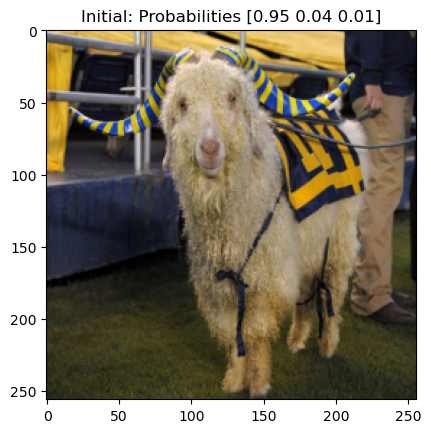

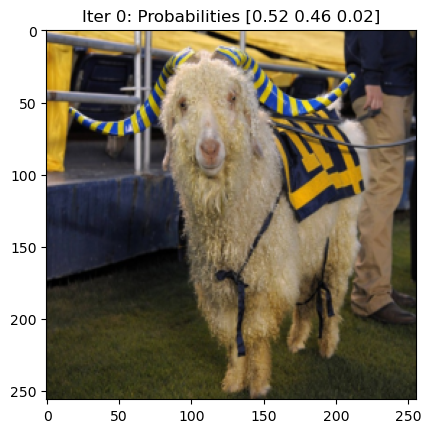

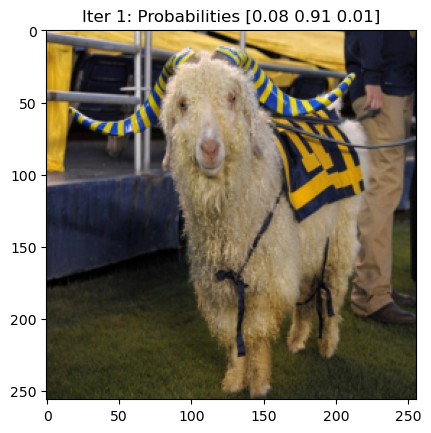

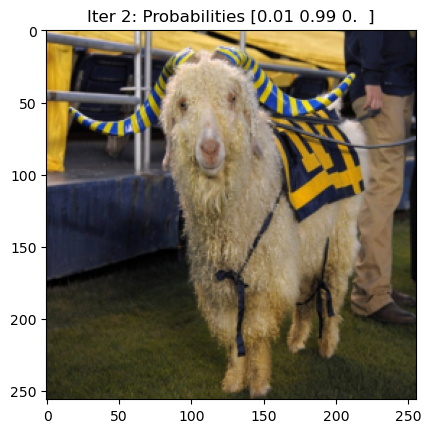

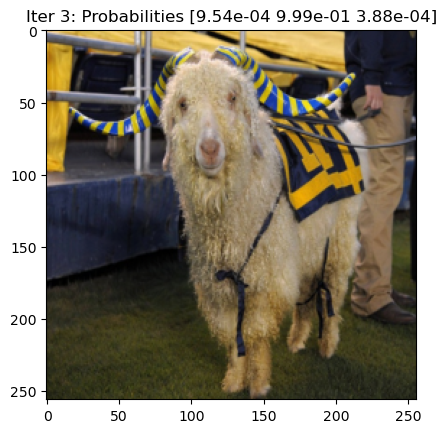

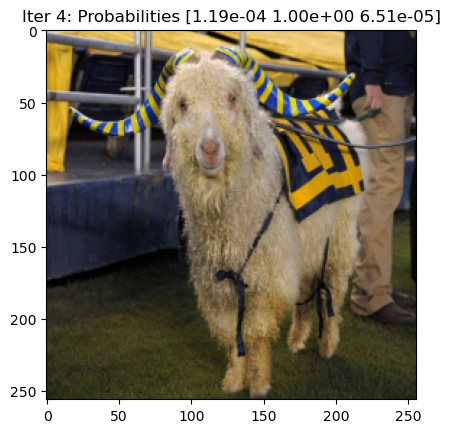

In [18]:
mygoat.retain_grad()
criterion = nn.CrossEntropyLoss()

np.set_printoptions(precision=2)

probs = checkProbs(mygoat, do_print=False)
plt.imshow(mygoat.detach().permute(1,2,0))
plt.title(f'Initial: Probabilities {probs[0].numpy()}')
plt.show()

muleProbs=[probs[0][1]]

for i in range(5):
    model.eval()
    preds = model(mygoat.unsqueeze(0).to('cuda'))
    loss = criterion(preds, desired_class_tens)
    model.zero_grad()
    loss.backward()
    mygoat = fgsm_attack(mygoat, .001, mygoat.grad.data)
    mygoat.requires_grad = True
    mygoat.retain_grad()

    probs = checkProbs(mygoat, do_print=False)
    plt.imshow(mygoat.detach().permute(1,2,0))
    plt.title(f'Iter {i}: Probabilities {probs[0].numpy()}')
    plt.show()
    muleProbs.append(probs[0][1])


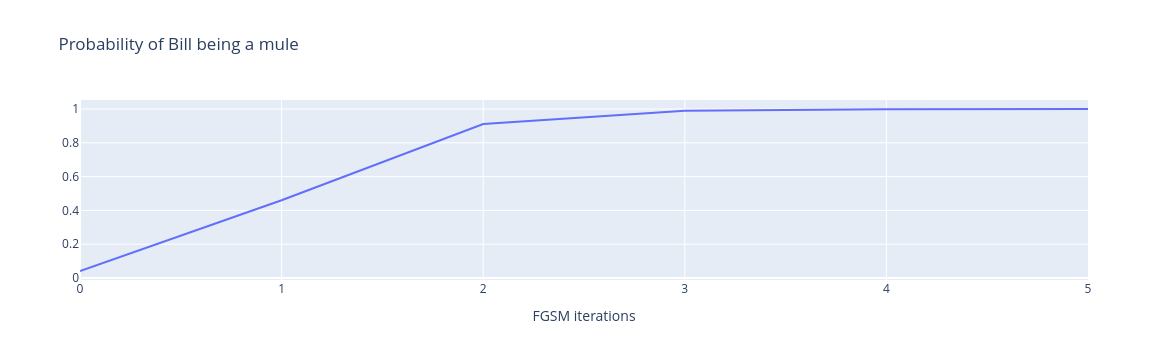

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(6)), y=muleProbs, mode='lines'))
fig.update_layout(
    title='Probability of Bill being a mule',
    xaxis_title='FGSM iterations'
)
fig.show()

Lastly, we calculate the total change between the altered goat and original goat.  You can see that the pixel values have barely been changed at all.  We can visualize these changes by increasing their magnitude significantly, and displaying the difference.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-0.0050,  0.0010,  0.0050,  ...,  0.0050,  0.0050, -0.0010],
         [-0.0030,  0.0050, -0.0030,  ...,  0.0030,  0.0030,  0.0050],
         [ 0.0050,  0.0050, -0.0050,  ..., -0.0030, -0.0030, -0.0030],
         ...,
         [ 0.0050, -0.0050, -0.0030,  ...,  0.0010,  0.0050, -0.0030],
         [-0.0010,  0.0050, -0.0050,  ...,  0.0050, -0.0010, -0.0030],
         [-0.0010,  0.0030, -0.0030,  ...,  0.0030,  0.0050, -0.0050]],

        [[-0.0050,  0.0010,  0.0050,  ...,  0.0050,  0.0050, -0.0010],
         [-0.0030, -0.0010, -0.0050,  ...,  0.0050,  0.0050,  0.0050],
         [ 0.0010, -0.0010, -0.0050,  ...,  0.0050,  0.0050,  0.0030],
         ...,
         [-0.0050, -0.0050,  0.0030,  ...,  0.0050,  0.0050,  0.0050],
         [-0.0010,  0.0050, -0.0030,  ...,  0.0050, -0.0030, -0.0030],
         [-0.0010,  0.0010, -0.0030,  ..., -0.0030, -0.0010, -0.0030]],

        [[-0.0030,  0.0030,  0.0050,  ..., -0.0050,  0.0010, -0.0010],
         [-0.0050,  0.0050,  0.0050,  ..., -0

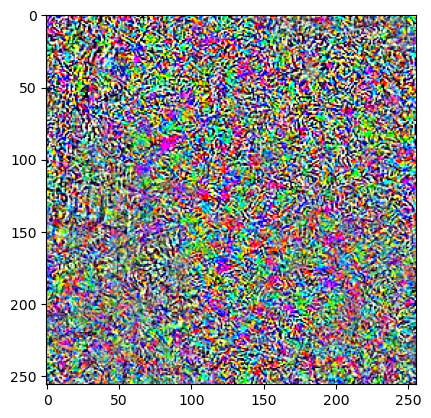

In [20]:
change=mygoat-initial_goat
change=change.detach()
print(change)
change = 100*change+.5
plt.imshow(change.permute(1,2,0))
plt.show()